# Defouling Area and Shape 

### The primary objective of the provided code is to determine the de-fouling area of a membrane subjected to particle-laden flow. The model calculates the distance x at which the force due to fouling particles equals the force exerted by the permeate flux. This distance is a function of various parameters including particle diameter (d_p), membrane pore diameter (d_m), and other fluid dynamics properties such as the density (ρ) and viscosity (μ) of the feed, the impinging angle (φ), and the initial jet velocity (U_0).

### To find x, the find_x function employs a root-finding algorithm (root_scalar) that solves for x where the fouling force (F_D) balances the permeate flux force (F_j). The integration of x over the angle θ from 0 to 2π yields the de-fouling area. The sector area for each θ is calculated and summed to determine the total de-fouling area.

### The provided code includes detailed functions for calculating relevant parameters such as the Reynolds number (Re_D), wall shear stress (τ_wall), and other intermediary values essential for the root-finding process. Additionally, the script visualizes the de-fouling area by plotting x values as a function of θ, illustrating the de-fouling region. It also calculates and displays the major and minor axes of the area, providing a comprehensive analysis of the de-fouling pattern.

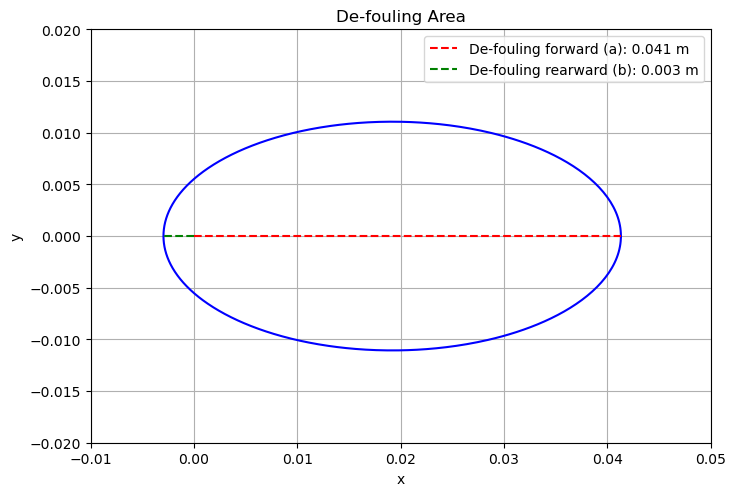

For θ = 0.0000, x = 0.0413 m
For θ = 3.1416, x = 0.0030 m
De-fouling area: 0.000782 m2


In [1]:
############ Logic ############

# 1. x is a distance that makes M=0 
# 2. find x (x is funciton of multiple parameters)
# 3. integrate x with respect to θ from 0 to 2π  →  de-fouling area


############ Import packages ############

import numpy as np
from scipy.optimize import root_scalar
from scipy.integrate import quad
import matplotlib.pyplot as plt

############ Parameters ############

d_p = 2.7E-06 # particle diameter
d_m = 2.0E-07 # membrane pore diameter
d = 3.0E-04 # nozzle diameter

rho = 1000 # density of feed
mu = 8.90E-04 # dynamic viscosity of feed
nu = 8.90E-07 # kinematic viscosity of feed

phi = np.radians(30)  # impinging angle, conversion to radians

j = 3.05E-05 # permeate flux in ms-1
R_m = 6.74E+11 # membrane resistance

U_0 = 41 # initial jet velocity


############ Define functions ############

def alpha(d_m, d_p):
    return np.arcsin(0.5 * d_m / d_p) 

def Re_D(U_0, d, nu):
    return rho* U_0 * d / mu

def h(phi, theta):
    return 0.78/ np.sqrt(np.sin(phi)) * (1 + np.cos(phi) * np.cos(theta)) / (np.cos(theta)**2 + (np.sin(theta) / np.sin(phi))**2)

def tau_wall(Re_D_val, rho, U_m_val):
    return 0.098 * Re_D_val**(-1/5) * 0.5 * rho * U_m_val**2

def gamma(tau_wall_val, nu):
    return tau_wall_val / nu 

def F_D(tau_wall_val, d_p):
    return tau_wall_val * d_p**2

def F_j(R_m, d, mu, d_p, j):
    return np.sqrt(R_m * d_p / 3 + 1.072**2) * 3 * mu * np.pi * d_p * j

# M function
def M(x, *args):
    rho, d_p, d, nu, phi, j, R_m, mu, U_0, theta = args
    h_val = h(phi, theta)
    U_m_val = h_val * (d / x) * U_0
    Re_D_val = Re_D(U_0, d, nu)
    tau_wall_val = tau_wall(Re_D_val, rho, U_m_val)
    gamma_val = gamma(tau_wall_val, nu)
    F_D_val = F_D(tau_wall_val, d_p)
    F_j_val = F_j(R_m, d, mu, d_p, j)
    alpha_val = alpha(d_m, d_p)
    return F_D_val * np.cos(alpha_val) - F_j_val * np.sin(alpha_val)

# find_x 
def find_x(theta, rho, d_p, d, nu, phi, j, R_m, mu, U_0):
    args = (rho, d_p, d, nu, phi, j, R_m, mu, U_0, theta)
    try:
        result = root_scalar(M, args=args, bracket=[0.00001, 100], method='brentq', xtol=1e-10, rtol=1e-10)
        return result.root if result.converged else None
    except ValueError:
        return None

    #method = brentq, bisect, newton, ridder
   
######## Sector Area Calculation ######
def sector_area(theta, rho, d_p, d, nu, phi, j, R_m, mu, U_0):
    x = find_x(theta, rho, d_p, d, nu, phi, j, R_m, mu, U_0)
    if x is not None:
        # Calculate the radius of the sector
        r = x
        # Calculate the angle subtended by the sector
        delta_theta = 2 * np.pi / 360  # Convert to radians
        # Calculate the area of the sector
        area = 0.5 * r**2 * delta_theta
        return area
    else:
        return 0

# fouling_removal_area function
def fouling_removal_area(rho, d_p, d, nu, phi, j, R_m, mu, U_0):
    total_area = 0
    # Sum the areas of the sectors over the entire range of theta
    for theta in np.linspace(0, 2*np.pi, num=360):
        total_area += sector_area(theta, rho, d_p, d, nu, phi, j, R_m, mu, U_0)
    return total_area



############### Figure ###############

# given theta values
theta_values = np.linspace(0, 2*np.pi, num=1000)

# calculate x for given theta values
x_values = []
for theta in theta_values:
    x = find_x(theta, rho, d_p, d, nu, phi, j, R_m, mu, U_0)
    if x is not None:
        x_values.append(x)

# Plot the fouling removal area
plt.figure(figsize=(8, 6))
plt.plot(x_values * np.cos(theta_values), x_values * np.sin(theta_values), color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('De-fouling Area')

# Calculate and plot the major and minor axes
a = max(x_values)
b = min(x_values)
plt.plot([0, a], [0, 0], linestyle='--', color='red', label=f'De-fouling forward (a): {a:.3f} m')
plt.plot([0, -b], [0, 0], linestyle='--', color='green', label=f'De-fouling rearward (b): {b:.3f} m')

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()

plt.xlim(-0.01, 0.05)
plt.ylim(-0.02, 0.02)

plt.show()



############ Print results ############

# given theta values
theta_values = [0, np.pi]

# print x for given theta values
for theta in theta_values:
    x = find_x(theta, rho, d_p, d, nu, phi, j, R_m, mu, U_0)
    if x is not None:
        print(f"For θ = {theta:.4f}, x = {x:.4f} m")
    else:
        print(f"For θ = {theta}, x not found")

# print area
area = fouling_removal_area(rho, d_p, d, nu, phi, j, R_m, mu, U_0)
print(f"De-fouling area: {area:.6f} m2")




# Multiple Nozzle Arrangements

In [2]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from ipywidgets import interact, IntSlider, FloatSlider

# Given parameters
d_p = 2.7E-06  # particle diameter
d_m = 2.0E-07 # membrane pore diameter
d = 3.3E-04  # nozzle diameter
rho = 1000  # density of feed
mu = 8.90E-04  # dynamic viscosity of feed
nu = 8.90E-07  # kinematic viscosity of feed
phi = np.radians(30)  # angle between edge and centerline, conversion to radians
j = 2.78E-05  # permeate flux in ms-1
R_m = 6.74E+11  # membrane resistance
U_0 = 33  # initial jet velocity

# Function definitions
def alpha(d_m, d_p):
    return np.arcsin(0.5 * d_m / d_p)

def Re_D(U_0, d, nu):
    return rho * U_0 * d / mu

def h(phi, theta):
    return 1.1 / np.sqrt(np.sin(phi)) * (1 + np.cos(phi) * np.cos(theta)) / (np.cos(theta)**2 + (np.sin(theta) / np.sin(phi))**2)

def tau_wall(Re_D_val, rho, U_m_val):
    return 0.098 * Re_D_val**(-1/5) * 0.5 * rho * U_m_val**2

def gamma(tau_wall_val, nu):
    return tau_wall_val / nu 

def F_D(tau_wall_val, d_p):
    return tau_wall_val * d_p**2

def F_j(R_m, d, mu, d_p, j):
    return np.sqrt(R_m * d_p / 3 + 1.072**2) * 3 * mu * np.pi * d_p * j

def M(x, *args):
    rho, d_p, d, nu, phi, j, R_m, mu, U_0, theta = args
    h_val = h(phi, theta)
    U_m_val = h_val * (d / x) * U_0
    Re_D_val = Re_D(U_0, d, nu)
    tau_wall_val = tau_wall(Re_D_val, rho, U_m_val)
    gamma_val = gamma(tau_wall_val, nu)
    F_D_val = F_D(tau_wall_val, d_p)
    F_j_val = F_j(R_m, d, mu, d_p, j)
    return F_D_val * np.cos(alpha(d_m, d_p)) - F_j_val * np.sin(alpha(d_m, d_p))

def find_x(theta, rho, d_p, d, nu, phi, j, R_m, mu, U_0):
    args = (rho, d_p, d, nu, phi, j, R_m, mu, U_0, theta)
    result = root_scalar(M, args=args, bracket=[0.00001, 100], method='brentq')
    return result.root if result.converged else None

# Plotting function with figure dimension control
def plot_nozzle_arrangement(rows, columns, distance_between_rows, distance_between_columns, figure_width, figure_height):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')
    
    for row in range(rows):
        for col in range(columns):
            center_x = col * distance_between_columns
            center_y = row * distance_between_rows + 0.003
            theta_values = np.linspace(0, 2 * np.pi, 360)
            x_values = [find_x(theta, rho, d_p, d, nu, phi, j, R_m, mu, U_0) for theta in theta_values]
            x_coords = [x * np.sin(theta) + center_x for x, theta in zip(x_values, theta_values)]
            y_coords = [x * np.cos(theta) + center_y for x, theta in zip(x_values, theta_values)]

            vertices = list(zip(x_coords, y_coords))  # Corrected this line
            codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices) - 2) + [Path.CLOSEPOLY]
            path = Path(vertices, codes)
            patch = PathPatch(path, edgecolor='r', facecolor='none', lw=1)
            ax.add_patch(patch)

    plt.xlim(0, figure_width)
    plt.ylim(0, figure_height)
    plt.title("Arrangement of Nozzles and Their De-fouling Areas")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")
    plt.grid(True)
    plt.show()

# Setup interactive controls with figure dimension sliders
interact(plot_nozzle_arrangement,
          rows=IntSlider(value=2, min=1, max=10, step=1, description='# Rows'),
         columns=IntSlider(value=2, min=1, max=10, step=1, description='# Col'),
         distance_between_rows=FloatSlider(value=0.5, min=0.01, max=0.05, step=0.01, description='D_Row (m)'),
         distance_between_columns=FloatSlider(value=0.5, min=0.01, max=0.05, step=0.01, description='D_Col (m)'),
         figure_width=FloatSlider(value=0.1, min=0.1, max=0.2, step=0.01, description='Width (m)'),
         figure_height=FloatSlider(value=0.4, min=0.1, max=0.4, step=0.05, description='Height (m)'))


interactive(children=(IntSlider(value=2, description='# Rows', max=10, min=1), IntSlider(value=2, description=…

<function __main__.plot_nozzle_arrangement(rows, columns, distance_between_rows, distance_between_columns, figure_width, figure_height)>